In [1]:
!pip3 install torchmetrics


[notice] A new release of pip available: 22.2.2 -> 23.0
[notice] To update, run: pip install --upgrade pip


In [2]:
%matplotlib inline
import torch

from torchvision import transforms

from PIL import Image
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F

import torchmetrics



import glob
from tqdm import tqdm

In [3]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"


### Подготовка данных

In [4]:
class CustomDataset(Dataset):

    def __init__(self, path='samples', transform=None):
        self.data = [(path, self._filename_encoding(path)) for path in glob.iglob(f'{path}/*')]
        self.transform = transform
        
    def _filename_encoding(self, filepath):
        filename = filepath[filepath.rfind('/') + 1: filepath.rfind('.')]
        encodded_message = []
        for let in filename:
            if ord(let) >= ord('0') and ord(let) <= ord('9'):
                encodded_message.append(ord('z') - ord('a') + int(let) + 1)
            else:
                encodded_message.append(ord(let) - ord('a'))
        return encodded_message
                
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        filepath, target = self.data[idx]
        img = Image.open(filepath).convert('L')
        
        if self.transform:
            sample = self.transform(sample)
        else:
            convert_tensor = transforms.ToTensor()
            sample = convert_tensor(img)

        return sample, torch.tensor(target)

In [19]:
data = CustomDataset()
train_dataset, test_dataset = train_test_split(data, test_size=0.2, random_state=42)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [20]:
for el, lab in train_loader:
    print(type(el), type(lab))
    break

<class 'torch.Tensor'> <class 'torch.Tensor'>


### Создание и обучение модели

In [21]:
class ConvPoolBlock(nn.Module):
    def __init__(self, in_channels, out_channels, conv_kernel=3, pool_kernel=2):
        super(ConvPoolBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=conv_kernel),
            nn.MaxPool2d(kernel_size=pool_kernel, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(p=0.15)
        )
    def forward(self, x):
        return self.conv_block(x)



class Network(nn.Module):

    def __init__(self, in_channels, num_classes=35):
        super(Network, self).__init__()

        self.conv_part = nn.Sequential(
            ConvPoolBlock(in_channels=1, out_channels=64, conv_kernel=3, pool_kernel=2),
            ConvPoolBlock(in_channels=64, out_channels=128, conv_kernel=3, pool_kernel=2),
            ConvPoolBlock(in_channels=128, out_channels=256, conv_kernel=3, pool_kernel=2), 
            ConvPoolBlock(in_channels=256, out_channels=512, conv_kernel=3, pool_kernel=2)
            )
        
        self.linear = nn.Linear(512, 128)
        self.lstm = nn.LSTM(128, 256, num_layers=2, bidirectional=True)
        self.linear_final = nn.Linear(2 * 256, num_classes)
        
    def forward(self, x):
        out = self.conv_part(x)
        b, c, h, w = out.size()
        out = out.view(b, -1, w).permute(0, 2, 1)
        out = self.linear(out).permute(1, 0, 2)
        out, _ = self.lstm(out)
        out = self.linear_final(out)
    
        input_lengths = torch.full(size=(out.size(1),), fill_value=out.size(0), dtype=torch.int32)
        target_lengths = torch.full(size=(out.size(1),), fill_value=5, dtype=torch.int32)
        return out, input_lengths, target_lengths

In [22]:
def decode_nums(preds):
    result = []
    for word in preds:
        predicted = []
        for symb in word:
            if symb > ord('z') - ord('a'):
                symb -= ord('z') - ord('a') + 1
                predicted.append(str(symb))
            else:
                symb += ord('a')
                predicted.append(chr(symb))
        result.append(''.join(predicted))
    return result
        

In [27]:
def epoch_train(loader, clf, criterion, opt, metric):
    clf.train(True)
    loss_list, cte_list = [], []
    for img, label in loader:
        img, labels = img.to(device), label.to(device) 

        out, input_lengths, target_lengths = clf.forward(img)
        log_prob = F.log_softmax(out, dim=2)

        loss = criterion(log_prob, labels, input_lengths, target_lengths)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        out = out.permute(1, 0, 2)
        out = out.log_softmax(2)
        out = out.argmax(-1)
        
        decoded_out = decode_nums(out)
        decoded_labels = decode_nums(labels)

        loss_list.append(loss.item())
        cte_list.append(metric(decoded_out, decoded_labels).item())
        
    return sum(loss_list)/len(loader), sum(cte_list) / len(loader) 
 
    # END Solution (do not delete this comment!)
    
def epoch_test(loader, clf, criterion, metric):
    # BEGIN Solution (do not delete this comment!)

    clf.eval()
    loss_list, cte_list = [], []
    for img, label in loader:
        img, labels = img.to(device), label.to(device) 
        out, input_lengths, target_lengths = clf.forward(img)
        log_prob = F.log_softmax(out, dim=2)

        loss = criterion(log_prob, labels, input_lengths, target_lengths)
        
       
        out = out.permute(1, 0, 2)
        out = out.log_softmax(2)
        out = out.argmax(-1)
        
        decoded_out = decode_nums(out)
        decoded_labels = decode_nums(labels)

        loss_list.append(loss.item())
        cte_list.append(metric(decoded_out, decoded_labels).item())
        
    return sum(loss_list)/len(loader), sum(cte_list) / len(loader) 
    # END Solution (do not delete this comment!)

# The function which you are going to use for model training
def train(train_loader, test_loader, clf, criterion, opt, metric, n_epochs=50):
    tr_loss_lst, tst_loss_lst, tr_cte_lst, tst_cte_lst = [], [], [], []
    for epoch in tqdm(range(n_epochs)):
        train_loss, train_cte = epoch_train(train_loader, clf, criterion, opt, metric)
        test_loss, test_cte = epoch_test(test_loader, clf, criterion, metric)

        tr_loss_lst.append(train_loss)
        tst_loss_lst.append(test_loss)
        tr_cte_lst.append(train_cte)
        tst_cte_lst.append(test_cte)
        
      
        

        print(f'[Epoch {epoch + 1}] train loss: {train_loss:.4f}; train CTE: {train_cte:.4f}; ' + 
              f'test loss: {test_loss:.3f}; test CTE: {test_cte:.4f}')
    return tr_loss_lst, tst_loss_lst, tr_cte_lst, tst_cte_lst 

In [29]:
model = Network(in_channels=1).to(device)
opt = torch.optim.Adam(model.parameters(), lr=4e-3)
# scheduler = ReduceLROnPlateau(opt, 'max')
scheduler = None
loss_func = nn.CTCLoss()
metric = torchmetrics.CharErrorRate()
loss_train, tst_loss, tr_cte, tst_cte  = train(train_loader, test_loader, model, loss_func, opt, metric, n_epochs=100)# Your experiments, training and validation loops here

  1%|▍                                          | 1/100 [00:02<03:20,  2.02s/it]

[Epoch 1] train loss: 3.5667; train CTE: 0.9663; test loss: 3.290; test CTE: 0.9726


  2%|▊                                          | 2/100 [00:03<03:12,  1.96s/it]

[Epoch 2] train loss: 3.2524; train CTE: 0.9756; test loss: 3.255; test CTE: 0.9726


  3%|█▎                                         | 3/100 [00:05<03:09,  1.95s/it]

[Epoch 3] train loss: 3.0991; train CTE: 0.9808; test loss: 3.101; test CTE: 0.9726


  4%|█▋                                         | 4/100 [00:08<03:49,  2.39s/it]

[Epoch 4] train loss: 2.8056; train CTE: 0.7252; test loss: 2.624; test CTE: 0.4500


  5%|██▏                                        | 5/100 [00:12<04:38,  2.93s/it]

[Epoch 5] train loss: 2.3300; train CTE: 0.4822; test loss: 2.224; test CTE: 0.4244


  6%|██▌                                        | 6/100 [00:17<05:15,  3.35s/it]

[Epoch 6] train loss: 1.9178; train CTE: 0.4006; test loss: 1.796; test CTE: 0.3040


  7%|███                                        | 7/100 [00:21<05:46,  3.72s/it]

[Epoch 7] train loss: 1.3207; train CTE: 0.2912; test loss: 1.170; test CTE: 0.2795


  8%|███▍                                       | 8/100 [00:26<06:08,  4.01s/it]

[Epoch 8] train loss: 0.8463; train CTE: 0.2320; test loss: 0.740; test CTE: 0.1980


  9%|███▊                                       | 9/100 [00:30<06:23,  4.22s/it]

[Epoch 9] train loss: 0.6092; train CTE: 0.2255; test loss: 0.777; test CTE: 0.1965


 10%|████▏                                     | 10/100 [00:35<06:31,  4.36s/it]

[Epoch 10] train loss: 0.4541; train CTE: 0.1878; test loss: 0.695; test CTE: 0.1887


 11%|████▌                                     | 11/100 [00:40<06:36,  4.45s/it]

[Epoch 11] train loss: 0.3228; train CTE: 0.1750; test loss: 0.394; test CTE: 0.1432


 12%|█████                                     | 12/100 [00:44<06:37,  4.52s/it]

[Epoch 12] train loss: 0.2140; train CTE: 0.1622; test loss: 0.441; test CTE: 0.1656


 13%|█████▍                                    | 13/100 [00:49<06:37,  4.56s/it]

[Epoch 13] train loss: 0.2161; train CTE: 0.1675; test loss: 0.460; test CTE: 0.1439


 14%|█████▉                                    | 14/100 [00:54<06:35,  4.59s/it]

[Epoch 14] train loss: 0.1953; train CTE: 0.1604; test loss: 0.502; test CTE: 0.1637


 15%|██████▎                                   | 15/100 [00:58<06:33,  4.62s/it]

[Epoch 15] train loss: 0.1254; train CTE: 0.1630; test loss: 0.346; test CTE: 0.1405


 16%|██████▋                                   | 16/100 [01:03<06:29,  4.63s/it]

[Epoch 16] train loss: 0.1122; train CTE: 0.1587; test loss: 0.297; test CTE: 0.1453


 17%|███████▏                                  | 17/100 [01:08<06:25,  4.64s/it]

[Epoch 17] train loss: 0.0951; train CTE: 0.1544; test loss: 0.268; test CTE: 0.1405


 18%|███████▌                                  | 18/100 [01:12<06:21,  4.65s/it]

[Epoch 18] train loss: 0.0789; train CTE: 0.1461; test loss: 0.363; test CTE: 0.1381


 19%|███████▉                                  | 19/100 [01:17<06:16,  4.65s/it]

[Epoch 19] train loss: 0.0677; train CTE: 0.1444; test loss: 0.330; test CTE: 0.1386


 20%|████████▍                                 | 20/100 [01:22<06:12,  4.65s/it]

[Epoch 20] train loss: 0.0456; train CTE: 0.1494; test loss: 0.327; test CTE: 0.1609


 21%|████████▊                                 | 21/100 [01:26<06:08,  4.66s/it]

[Epoch 21] train loss: 0.1076; train CTE: 0.1575; test loss: 0.485; test CTE: 0.1605


 22%|█████████▏                                | 22/100 [01:31<06:03,  4.66s/it]

[Epoch 22] train loss: 0.0671; train CTE: 0.1537; test loss: 0.398; test CTE: 0.1573


 23%|█████████▋                                | 23/100 [01:36<06:00,  4.68s/it]

[Epoch 23] train loss: 0.0620; train CTE: 0.1577; test loss: 0.362; test CTE: 0.1563


 24%|██████████                                | 24/100 [01:40<05:56,  4.70s/it]

[Epoch 24] train loss: 0.0417; train CTE: 0.1463; test loss: 0.328; test CTE: 0.1374


 25%|██████████▌                               | 25/100 [01:45<05:52,  4.70s/it]

[Epoch 25] train loss: 0.0346; train CTE: 0.1507; test loss: 0.305; test CTE: 0.1504


 26%|██████████▉                               | 26/100 [01:50<05:48,  4.72s/it]

[Epoch 26] train loss: 0.0309; train CTE: 0.1499; test loss: 0.316; test CTE: 0.1411


 27%|███████████▎                              | 27/100 [01:55<05:44,  4.72s/it]

[Epoch 27] train loss: 0.0621; train CTE: 0.1543; test loss: 0.345; test CTE: 0.1447


 28%|███████████▊                              | 28/100 [01:59<05:41,  4.74s/it]

[Epoch 28] train loss: 0.0623; train CTE: 0.1601; test loss: 0.361; test CTE: 0.1762


 29%|████████████▏                             | 29/100 [02:04<05:36,  4.74s/it]

[Epoch 29] train loss: 0.0517; train CTE: 0.1554; test loss: 0.327; test CTE: 0.1590


 30%|████████████▌                             | 30/100 [02:09<05:32,  4.75s/it]

[Epoch 30] train loss: 0.0610; train CTE: 0.1718; test loss: 0.318; test CTE: 0.1683


 31%|█████████████                             | 31/100 [02:14<05:27,  4.74s/it]

[Epoch 31] train loss: 0.0729; train CTE: 0.1689; test loss: 0.335; test CTE: 0.1493


 32%|█████████████▍                            | 32/100 [02:18<05:23,  4.75s/it]

[Epoch 32] train loss: 0.0316; train CTE: 0.1656; test loss: 0.308; test CTE: 0.1487


 33%|█████████████▊                            | 33/100 [02:23<05:18,  4.75s/it]

[Epoch 33] train loss: 0.0240; train CTE: 0.1612; test loss: 0.273; test CTE: 0.1413


 34%|██████████████▎                           | 34/100 [02:28<05:13,  4.75s/it]

[Epoch 34] train loss: 0.0177; train CTE: 0.1561; test loss: 0.259; test CTE: 0.1373


 35%|██████████████▋                           | 35/100 [02:33<05:08,  4.75s/it]

[Epoch 35] train loss: 0.0145; train CTE: 0.1585; test loss: 0.272; test CTE: 0.1378


 36%|███████████████                           | 36/100 [02:37<05:03,  4.74s/it]

[Epoch 36] train loss: 0.0106; train CTE: 0.1437; test loss: 0.295; test CTE: 0.1376


 37%|███████████████▌                          | 37/100 [02:42<04:58,  4.74s/it]

[Epoch 37] train loss: 0.0103; train CTE: 0.1520; test loss: 0.294; test CTE: 0.1449


 38%|███████████████▉                          | 38/100 [02:47<04:54,  4.74s/it]

[Epoch 38] train loss: 0.0145; train CTE: 0.1562; test loss: 0.314; test CTE: 0.1567


 39%|████████████████▍                         | 39/100 [02:52<04:48,  4.74s/it]

[Epoch 39] train loss: 0.0182; train CTE: 0.1539; test loss: 0.333; test CTE: 0.1356


 40%|████████████████▊                         | 40/100 [02:56<04:43,  4.73s/it]

[Epoch 40] train loss: 0.0231; train CTE: 0.1486; test loss: 0.320; test CTE: 0.1436


 41%|█████████████████▏                        | 41/100 [03:01<04:38,  4.73s/it]

[Epoch 41] train loss: 0.0488; train CTE: 0.1475; test loss: 0.346; test CTE: 0.1333


 42%|█████████████████▋                        | 42/100 [03:06<04:34,  4.73s/it]

[Epoch 42] train loss: 0.0537; train CTE: 0.1616; test loss: 0.347; test CTE: 0.1325


 43%|██████████████████                        | 43/100 [03:10<04:29,  4.72s/it]

[Epoch 43] train loss: 0.0387; train CTE: 0.1540; test loss: 0.322; test CTE: 0.1383


 44%|██████████████████▍                       | 44/100 [03:15<04:24,  4.72s/it]

[Epoch 44] train loss: 0.0580; train CTE: 0.1608; test loss: 0.317; test CTE: 0.1462


 45%|██████████████████▉                       | 45/100 [03:20<04:19,  4.72s/it]

[Epoch 45] train loss: 0.0461; train CTE: 0.1516; test loss: 0.257; test CTE: 0.1594


 46%|███████████████████▎                      | 46/100 [03:25<04:15,  4.73s/it]

[Epoch 46] train loss: 0.0500; train CTE: 0.1730; test loss: 0.282; test CTE: 0.1366


 47%|███████████████████▋                      | 47/100 [03:29<04:11,  4.74s/it]

[Epoch 47] train loss: 0.0306; train CTE: 0.1558; test loss: 0.307; test CTE: 0.1629


 48%|████████████████████▏                     | 48/100 [03:34<04:06,  4.74s/it]

[Epoch 48] train loss: 0.0172; train CTE: 0.1566; test loss: 0.280; test CTE: 0.1446


 49%|████████████████████▌                     | 49/100 [03:39<04:00,  4.72s/it]

[Epoch 49] train loss: 0.0115; train CTE: 0.1392; test loss: 0.300; test CTE: 0.1520


 50%|█████████████████████                     | 50/100 [03:43<03:54,  4.69s/it]

[Epoch 50] train loss: 0.0077; train CTE: 0.1487; test loss: 0.314; test CTE: 0.1514


 51%|█████████████████████▍                    | 51/100 [03:48<03:48,  4.67s/it]

[Epoch 51] train loss: 0.0158; train CTE: 0.1559; test loss: 0.342; test CTE: 0.1887


 52%|█████████████████████▊                    | 52/100 [03:53<03:43,  4.66s/it]

[Epoch 52] train loss: 0.0248; train CTE: 0.1650; test loss: 0.287; test CTE: 0.1687


 53%|██████████████████████▎                   | 53/100 [03:57<03:38,  4.65s/it]

[Epoch 53] train loss: 0.0168; train CTE: 0.1591; test loss: 0.324; test CTE: 0.1577


 54%|██████████████████████▋                   | 54/100 [04:02<03:33,  4.64s/it]

[Epoch 54] train loss: 0.0085; train CTE: 0.1537; test loss: 0.326; test CTE: 0.1347


 55%|███████████████████████                   | 55/100 [04:07<03:28,  4.63s/it]

[Epoch 55] train loss: 0.0098; train CTE: 0.1443; test loss: 0.331; test CTE: 0.1470


 56%|███████████████████████▌                  | 56/100 [04:11<03:23,  4.62s/it]

[Epoch 56] train loss: 0.0055; train CTE: 0.1434; test loss: 0.313; test CTE: 0.1505


 57%|███████████████████████▉                  | 57/100 [04:16<03:18,  4.62s/it]

[Epoch 57] train loss: 0.0060; train CTE: 0.1540; test loss: 0.325; test CTE: 0.1689


 58%|████████████████████████▎                 | 58/100 [04:20<03:13,  4.62s/it]

[Epoch 58] train loss: 0.0043; train CTE: 0.1484; test loss: 0.328; test CTE: 0.1459


 59%|████████████████████████▊                 | 59/100 [04:25<03:09,  4.61s/it]

[Epoch 59] train loss: 0.0052; train CTE: 0.1537; test loss: 0.317; test CTE: 0.1432


 60%|█████████████████████████▏                | 60/100 [04:30<03:04,  4.61s/it]

[Epoch 60] train loss: 0.0143; train CTE: 0.1589; test loss: 0.342; test CTE: 0.1594


 61%|█████████████████████████▌                | 61/100 [04:34<03:01,  4.66s/it]

[Epoch 61] train loss: 0.0266; train CTE: 0.1654; test loss: 0.319; test CTE: 0.1656


 62%|██████████████████████████                | 62/100 [04:39<02:58,  4.69s/it]

[Epoch 62] train loss: 0.0207; train CTE: 0.1587; test loss: 0.320; test CTE: 0.1564


 63%|██████████████████████████▍               | 63/100 [04:44<02:53,  4.69s/it]

[Epoch 63] train loss: 0.0277; train CTE: 0.1542; test loss: 0.356; test CTE: 0.1680


 64%|██████████████████████████▉               | 64/100 [04:49<02:48,  4.69s/it]

[Epoch 64] train loss: 0.0221; train CTE: 0.1582; test loss: 0.321; test CTE: 0.1623


 65%|███████████████████████████▎              | 65/100 [04:53<02:44,  4.70s/it]

[Epoch 65] train loss: 0.0150; train CTE: 0.1615; test loss: 0.289; test CTE: 0.1216


 66%|███████████████████████████▋              | 66/100 [04:58<02:40,  4.73s/it]

[Epoch 66] train loss: 0.0279; train CTE: 0.1527; test loss: 0.288; test CTE: 0.1557


 67%|████████████████████████████▏             | 67/100 [05:03<02:37,  4.77s/it]

[Epoch 67] train loss: 0.0278; train CTE: 0.1528; test loss: 0.254; test CTE: 0.1360


 68%|████████████████████████████▌             | 68/100 [05:08<02:33,  4.80s/it]

[Epoch 68] train loss: 0.0525; train CTE: 0.1616; test loss: 0.963; test CTE: 0.2201


 69%|████████████████████████████▉             | 69/100 [05:12<02:28,  4.79s/it]

[Epoch 69] train loss: 0.0413; train CTE: 0.1648; test loss: 0.286; test CTE: 0.1410


 70%|█████████████████████████████▍            | 70/100 [05:17<02:23,  4.78s/it]

[Epoch 70] train loss: 0.0366; train CTE: 0.1671; test loss: 0.273; test CTE: 0.1620


 71%|█████████████████████████████▊            | 71/100 [05:22<02:17,  4.75s/it]

[Epoch 71] train loss: 0.0229; train CTE: 0.1532; test loss: 0.276; test CTE: 0.1463


 72%|██████████████████████████████▏           | 72/100 [05:27<02:12,  4.74s/it]

[Epoch 72] train loss: 0.0118; train CTE: 0.1560; test loss: 0.270; test CTE: 0.1556


 73%|██████████████████████████████▋           | 73/100 [05:31<02:07,  4.72s/it]

[Epoch 73] train loss: 0.0224; train CTE: 0.1568; test loss: 0.307; test CTE: 0.1629


 74%|███████████████████████████████           | 74/100 [05:36<02:02,  4.71s/it]

[Epoch 74] train loss: 0.0098; train CTE: 0.1576; test loss: 0.298; test CTE: 0.1561


 75%|███████████████████████████████▌          | 75/100 [05:41<01:57,  4.71s/it]

[Epoch 75] train loss: 0.0060; train CTE: 0.1663; test loss: 0.293; test CTE: 0.1400


 76%|███████████████████████████████▉          | 76/100 [05:45<01:52,  4.71s/it]

[Epoch 76] train loss: 0.0037; train CTE: 0.1612; test loss: 0.296; test CTE: 0.1562


 77%|████████████████████████████████▎         | 77/100 [05:50<01:48,  4.72s/it]

[Epoch 77] train loss: 0.0049; train CTE: 0.1634; test loss: 0.305; test CTE: 0.1626


 78%|████████████████████████████████▊         | 78/100 [05:55<01:43,  4.72s/it]

[Epoch 78] train loss: 0.0039; train CTE: 0.1661; test loss: 0.294; test CTE: 0.1595


 79%|█████████████████████████████████▏        | 79/100 [06:00<01:39,  4.73s/it]

[Epoch 79] train loss: 0.0033; train CTE: 0.1567; test loss: 0.302; test CTE: 0.1444


 80%|█████████████████████████████████▌        | 80/100 [06:04<01:34,  4.75s/it]

[Epoch 80] train loss: 0.0032; train CTE: 0.1488; test loss: 0.297; test CTE: 0.1517


 81%|██████████████████████████████████        | 81/100 [06:09<01:30,  4.75s/it]

[Epoch 81] train loss: 0.0104; train CTE: 0.1562; test loss: 0.285; test CTE: 0.1439


 82%|██████████████████████████████████▍       | 82/100 [06:14<01:25,  4.75s/it]

[Epoch 82] train loss: 0.0070; train CTE: 0.1487; test loss: 0.291; test CTE: 0.1570


 83%|██████████████████████████████████▊       | 83/100 [06:19<01:21,  4.77s/it]

[Epoch 83] train loss: 0.0033; train CTE: 0.1750; test loss: 0.306; test CTE: 0.1435


 84%|███████████████████████████████████▎      | 84/100 [06:24<01:16,  4.78s/it]

[Epoch 84] train loss: 0.0016; train CTE: 0.1540; test loss: 0.308; test CTE: 0.1396


 85%|███████████████████████████████████▋      | 85/100 [06:28<01:11,  4.79s/it]

[Epoch 85] train loss: 0.0019; train CTE: 0.1619; test loss: 0.310; test CTE: 0.1372


 86%|████████████████████████████████████      | 86/100 [06:33<01:06,  4.78s/it]

[Epoch 86] train loss: 0.0038; train CTE: 0.1512; test loss: 0.292; test CTE: 0.1364


 87%|████████████████████████████████████▌     | 87/100 [06:38<01:02,  4.77s/it]

[Epoch 87] train loss: 0.0022; train CTE: 0.1568; test loss: 0.301; test CTE: 0.1291


 88%|████████████████████████████████████▉     | 88/100 [06:43<00:57,  4.76s/it]

[Epoch 88] train loss: 0.0038; train CTE: 0.1484; test loss: 0.262; test CTE: 0.1338


 89%|█████████████████████████████████████▍    | 89/100 [06:47<00:52,  4.75s/it]

[Epoch 89] train loss: 0.0054; train CTE: 0.1518; test loss: 0.309; test CTE: 0.1265


 90%|█████████████████████████████████████▊    | 90/100 [06:52<00:47,  4.75s/it]

[Epoch 90] train loss: 0.0014; train CTE: 0.1506; test loss: 0.320; test CTE: 0.1209


 91%|██████████████████████████████████████▏   | 91/100 [06:57<00:42,  4.74s/it]

[Epoch 91] train loss: 0.0019; train CTE: 0.1479; test loss: 0.367; test CTE: 0.1313


 92%|██████████████████████████████████████▋   | 92/100 [07:02<00:37,  4.73s/it]

[Epoch 92] train loss: 0.0088; train CTE: 0.1525; test loss: 0.317; test CTE: 0.1332


 93%|███████████████████████████████████████   | 93/100 [07:06<00:33,  4.73s/it]

[Epoch 93] train loss: 0.0033; train CTE: 0.1506; test loss: 0.321; test CTE: 0.1298


 94%|███████████████████████████████████████▍  | 94/100 [07:11<00:28,  4.72s/it]

[Epoch 94] train loss: 0.0051; train CTE: 0.1634; test loss: 0.329; test CTE: 0.1595


 95%|███████████████████████████████████████▉  | 95/100 [07:16<00:23,  4.72s/it]

[Epoch 95] train loss: 0.0047; train CTE: 0.1578; test loss: 0.291; test CTE: 0.1452


 96%|████████████████████████████████████████▎ | 96/100 [07:20<00:18,  4.72s/it]

[Epoch 96] train loss: 0.0051; train CTE: 0.1506; test loss: 0.305; test CTE: 0.1628


 97%|████████████████████████████████████████▋ | 97/100 [07:25<00:14,  4.71s/it]

[Epoch 97] train loss: 0.0600; train CTE: 0.1618; test loss: 0.435; test CTE: 0.1717


 98%|█████████████████████████████████████████▏| 98/100 [07:30<00:09,  4.71s/it]

[Epoch 98] train loss: 0.0503; train CTE: 0.1748; test loss: 0.350; test CTE: 0.1486


 99%|█████████████████████████████████████████▌| 99/100 [07:34<00:04,  4.70s/it]

[Epoch 99] train loss: 0.0720; train CTE: 0.1659; test loss: 0.358; test CTE: 0.1513


100%|█████████████████████████████████████████| 100/100 [07:39<00:00,  4.60s/it]

[Epoch 100] train loss: 0.0581; train CTE: 0.1975; test loss: 0.339; test CTE: 0.1562


### Подсчет метрик

Во время решения я пытался по разному модифицировать сеть, изменяя глубину lstm, количество конволюционных блоков, но сеть отчаянно запоминала данные. В итоге хоть как-то помог решить проблему дропаут, хоть можно было использовать аугментацию, но я был не уверен, что это является корректным шагом в данной задаче. Для улучшения результатов можно было попробывать использовать scheduler, но как я отмечал ранее мне кажется что сеть именно переучивается, он может только усугубить ситуацию 

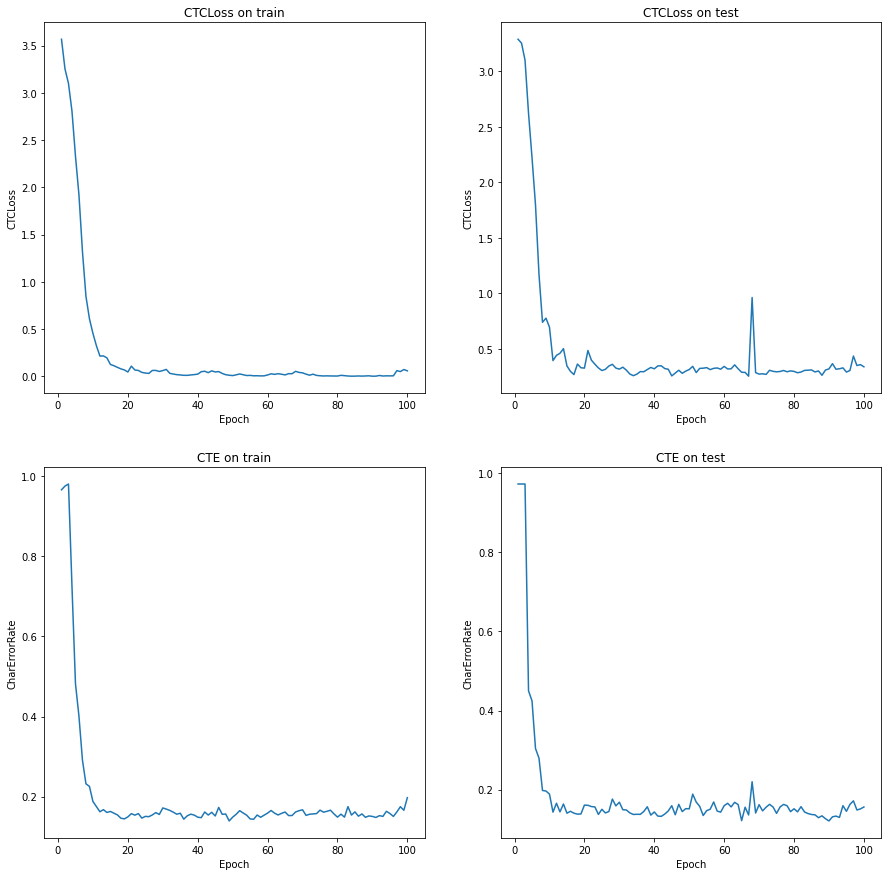

In [38]:
import matplotlib.pyplot as plt
figure, axis = plt.subplots(2, 2,  figsize=(15, 15))
X = [i for i in range(1, 101)]
  
axis[0, 0].plot(X, loss_train)
axis[0, 0].set_title("CTCLoss on train")
axis[0, 0].set_xlabel("Epoch")
axis[0, 0].set_ylabel('CTCLoss')
  
axis[0, 1].plot(X, tst_loss)
axis[0, 1].set_title("CTCLoss on test")
axis[0, 1].set_xlabel("Epoch")
axis[0, 1].set_ylabel('CTCLoss')
  
axis[1, 0].plot(X, tr_cte)
axis[1, 0].set_title("CTE on train")
axis[1, 0].set_xlabel("Epoch")
axis[1, 0].set_ylabel('CharErrorRate')
  
axis[1, 1].plot(X, tst_cte)
axis[1, 1].set_title("CTE on test")
axis[1, 1].set_xlabel("Epoch")
axis[1, 1].set_ylabel('CharErrorRate')
  
plt.show()

### Анализ ошибок модели.

In [75]:
dem_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
model.eval()
dem_list = []
for img, label in dem_loader:
    img, labels = img.to(device), label.to(device) 
    out, input_lengths, target_lengths = model.forward(img)

    out = out.permute(1, 0, 2)
    out = out.log_softmax(2)
    out = out.argmax(-1)

    decoded_out = decode_nums(out)
    decoded_labels = decode_nums(labels)

    dem_list.append((metric(decoded_out, decoded_labels).item(), decoded_out, decoded_labels))

In [76]:
dem_list.sort(reverse=True)

In [77]:
split = dem_list[:5]

In [96]:
for pos, (val, out, label) in enumerate(split):
    print(out, label)

["adatensor(2, device='cuda:1')xpppaa"] ['ddxpp']
['awanaaecaa'] ['wnpec']
['apbapaccaa'] ['pbpgc']
['apawanbnaa'] ['pwmbn']
['agyaaamnaa'] ['gymmn']


Идейно он их находит правильно, но он почему-то добаввляет а, возможно добавление - в статье было связанно с этим. 